# ***QA-VAC NOTEBOOK - Region Selection Plots from DP0***

Author: Gabriel Luan Souza de Oliveira.

Last update: 25/04/2022.

## ***Imported Modules***

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from astropy.table import Table
import healpy as hp
import copy
from gavodb import DBManager

## ***Loading Data***

### Calling DBManager

In [2]:
dbm = DBManager()

### Required infos and table names from pid

In [3]:
main_pid = '6941'
nside = 4096
nest = False
limit = False #False for complete tables, integer n for n rows.
verbose = False
table_names_from_pid = dbm.get_tablelist_from_pid(main_pid)
print(f'Tables from PID {main_pid}:',table_names_from_pid)

Tables from PID 6941: ['vac_cluster_simulation.footprint_6941', 'vac_cluster_simulation.catalog_6941']


### Footprint table

In [4]:
%%time
footprint_table = dbm.table_loading(main_pid,0,columns = None,limit = limit, verbose = verbose)

if 'ra' and 'dec' not in footprint_table.keys():
    ra,dec = hp.pix2ang(nside=nside, ipix=footprint_table['pixel'].astype(int), lonlat = True, nest = nest)
    ra[ra>180] -= 360
    footprint_table['ra'] = ra
    footprint_table['dec'] = dec
    print("'ra' and dec' columns add from healpy pixels.")
    
else:
    print("No columns added.")

No columns added.
CPU times: user 29.2 s, sys: 1.96 s, total: 31.1 s
Wall time: 31.5 s


In [5]:
footprint_table

ra,dec,pixel,signal
float64,float64,float64,float64
52.613525390625,-35.158924463064125,158624090.0,1.0
52.723388671875,-31.34448005576511,153020767.0,1.0
52.569580078125,-30.95220852676994,152430936.0,1.0
54.33837890625,-38.861605383212066,163817897.0,1.0
51.35009765625,-33.56599649269043,156313889.0,1.0
56.370849609375,-39.113554161266784,164162053.0,1.0
51.2841796875,-37.46203997383155,161884446.0,1.0
52.042236328125,-31.84811169122737,153774400.0,1.0
52.14111328125,-38.17032541731712,162867525.0,1.0


### Full catalog

In [6]:
%%time
#catalog = dbm.table_loading(main_pid,1,columns = ['ra','dec','coadd_objects_id','z_best'],limit = limit, verbose = verbose,
#                            footprint_table_name = table_names_from_pid[0], sorting_columns = ['coadd_objects_id','pixel'])
catalog = dbm.table_loading(main_pid,1,columns = ['ra','dec','coadd_objects_id','z_best'],limit = 500000, verbose = verbose)

CPU times: user 9.95 s, sys: 371 ms, total: 10.3 s
Wall time: 10.5 s


In [7]:
catalog

ra,dec,coadd_objects_id,z_best
float64,float64,float64,float64
50.7258,-37.744,1.5969598939595532e+16,0.30135003
50.729,-37.7455,1.5969598939600732e+16,1.6693203
50.7277,-37.7418,1.5969598939595552e+16,0.24109852
50.7299,-37.7434,1.5969598939597032e+16,1.5050558
50.7345,-37.7468,1.5969598939600726e+16,0.8958819
50.7379,-37.7477,1.59695989395955e+16,1.3746054
50.7348,-37.7461,1.5969598939600724e+16,0.16310692
50.7361,-37.7461,1.5969598939600728e+16,0.8964368
50.7355,-37.7445,1.596959893959703e+16,0.6955499


## ***Plots***

### Plot Functions

In [14]:
%reload_ext autoreload
def mask_func(signal,mask_dict):
    if mask_dict != None:
        assert mask_dict['relation'] in ('less','greater','equal'), 'Input key is not a valid string.'
        #assert type(signal).__name__ == 'ndarray', 'signal must be an numpy array (ndarray)'

        if mask_dict['relation'] == 'less':
            mask = signal < mask_dict['value']

        elif mask_dict['relation'] == 'greater':
            mask = signal > mask_dict['value']

        elif mask_dict['relation'] == 'equal':
            mask = signal == mask_dict['value']
    else:
         mask = signal == signal   
    return mask

def plot_map(ra,dec,signal, verbose = False, map_type = 'cartesian',**kwargs):

    ###-------------------------------------------###
    #                Key informations               #
    ###-------------------------------------------###
    
    nside = 4096
    steradian_in_degrees = (180./np.pi)**2
    sky_area = 4*np.pi*steradian_in_degrees   #Area of an sphere measured in degrees^2. Read more on https://www.mathsisfun.com/geometry/steradian.html
    npixels = hp.nside2npix(nside)            #Númeto de pixeis em um Healpix pixelization scheme => 12.0*(nside)**2.0
    area_of_each_pixel = sky_area/(npixels)   #In degrees^2.
    pix_area_arcmin = 3600*area_of_each_pixel #Pixel area in (minutes of degree)².
    
    if verbose == True:
        print('Number of pixels:',npixels,
              '\nSky area:', sky_area,'degrees²',
              '\nArea of each pixel:', area_of_each_pixel, 'degrees²;', pix_area_arcmin,'min^2')
    
    ###-------------------------------------------###
    #                     Mask                      #
    ###-------------------------------------------###
    mask = mask_func(signal, kwargs['mask_dict'])
    
    ###-------------------------------------------###
    #                     Plot                      #
    ###-------------------------------------------###
    
    if map_type == 'cartesian':
        
        # Fig config
        plt.clf()
        fig, ax = plt.subplots(1, figsize = (16,9))
        ax.set_facecolor('#696969')
    
        # To plot
        sc = ax.scatter(ra[mask], dec[mask], c = signal[mask],
                        vmin = kwargs['vmin'], vmax = kwargs['vmax'], cmap = kwargs['cmap'], 
                        marker = kwargs['marker'], s=kwargs['marker_size'], linewidths=kwargs['marker_linewidths'])

        # Axis Stuff
        #ax.set_xlim(0.9*np.nanmin(ra[mask]),1.1*np.nanmax(ra[mask]))
        #ax.set_ylim(0.9*np.nanmin(dec[mask]),1.1*np.nanmax(dec[mask]))
        ax.invert_xaxis()

        # Labels
        ax.set_xlabel('R.A. (degrees)', fontsize = 16)
        ax.set_ylabel('DEC. (degrees)', fontsize = 16)
        ax.set_title(kwargs['title'], fontsize = 20, weight='bold')
        ax.tick_params(axis='both', which='major', labelsize=16)

        # Colorbar
        if kwargs['colorbar'] == True:
            cbar = fig.colorbar(sc, ax = [ax], location = 'right', pad = 0)
            cbar.set_label(kwargs['barlabel'], fontsize = 16, labelpad = 12.0)
            cbar.set_ticks(kwargs['setticks'])
            cbar.ax.tick_params(labelsize=16)

        plt.show()  

### Footprint Map

<Figure size 640x480 with 0 Axes>

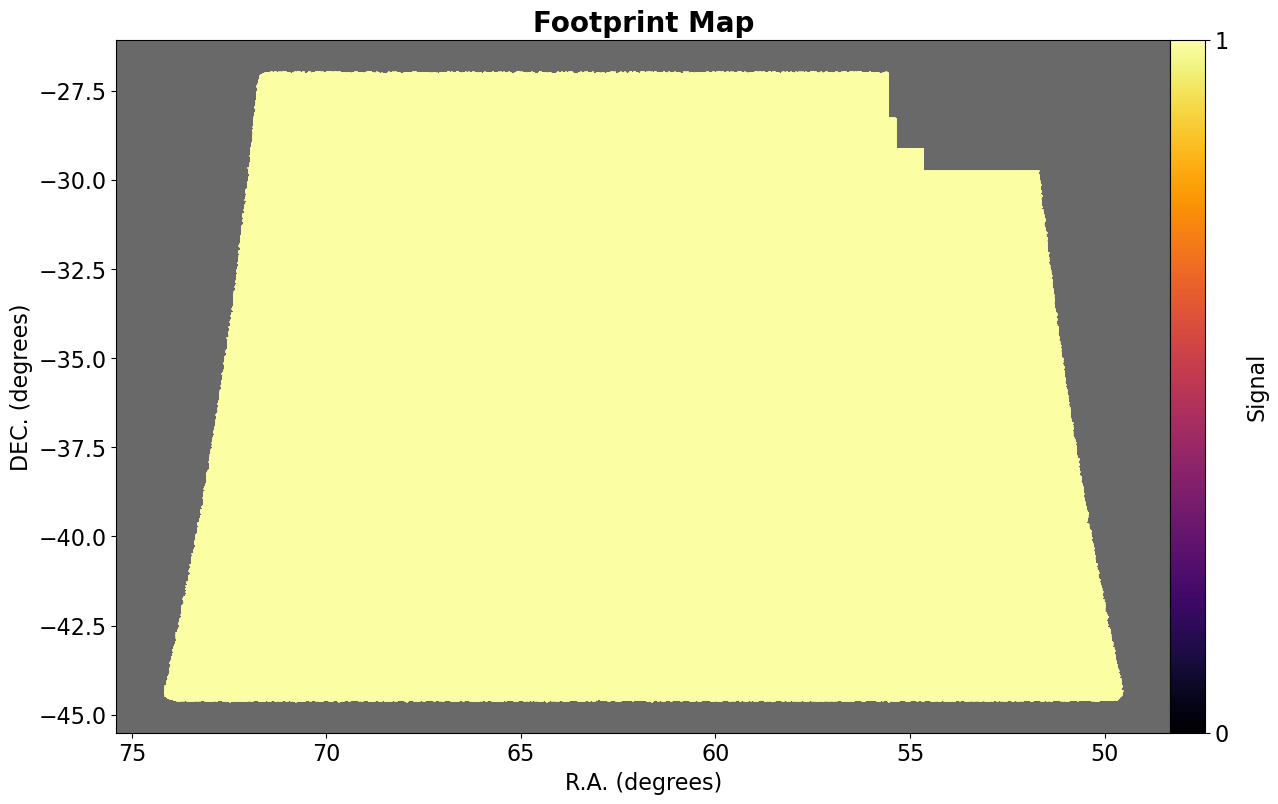

In [19]:
params = {'title':f"Footprint Map",
          'barlabel':"Signal",
          'vmin':0,
          'vmax':1,
          'cmap':cm.inferno,
          'setticks':[0,1],
          'mask_dict': None,
          'colorbar': True,
          'marker':',',
          'marker_size':0.5,
          'marker_linewidths':0.5
         }

plot_map(footprint_table['ra'],footprint_table['dec'], footprint_table['signal'],'cartesian', **params)